# Table of contents

1. Empirical Frequencies in the PILE dataset
2. GPT-Neo-125M estimated probabilities

We will start by analizing some marginals and see how the model relates to that.


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

## Verify queries are encoded as single tokens

This verification is necessary because the current method does not consider contiguous sequences of tokens.

In [49]:
from importance_sampler import ImportanceSampler

DEVICE = "cuda"
MAX_NUM_TOKENS = 15
MODEL_NAME = "EleutherAI/gpt-neo-125M"
NUM_SEQUENCES = 250
SEED = 20230126

sampler = ImportanceSampler(
    model_name=MODEL_NAME,
    device=DEVICE,
)

# TODO: (get code from commit -- removed now for simplicity)

Using pad_token, but it is not set yet.


Importing classes for model EleutherAI/gpt-neo-125M
 -> <class 'transformers.models.gpt2.tokenization_gpt2.GPT2Tokenizer'>
 -> <class 'transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM'>
Vocabulary size: 50257


In [56]:
sampler.tokenizer("biodata")

{'input_ids': [65, 2101, 1045], 'attention_mask': [1, 1, 1]}

In [ ]:
sampler.tokenizer(["da", "ta"])

In [57]:
sampler.tokenizer("bio data")

{'input_ids': [65, 952, 1366], 'attention_mask': [1, 1, 1]}

In [3]:
from functools import partial

model_estimate = partial(
    sampler.estimate_hit_probability, 
    input_str=None,
    num_sequences=NUM_SEQUENCES,
    max_num_tokens=MAX_NUM_TOKENS,
    seed=SEED
)

## "Proxy" Empirical frequencies in PILE dataset

In [4]:
import pickle

# --------------------------------------------------------------------
# This file contains all the term frequencies of the PILE datset.
# This file was created by Yasaman Razhegi on Jan 2021. 
# It contains several optimizations (that enabled us to reduce the size of the file):
# - Removed stopwords
# - Tokenized words using spacy (which may have led to dropping some terms) 
# - Pruned lower frequency terms
# --------------------------------------------------------------------
with open('./term_frequency.pkl', 'rb') as f:
    TERM_FREQUENCY = pickle.load(f)
    
PROXY_ALL_TERMS = sum(TERM_FREQUENCY.values())
PROXY_ALL_TERMS
print("Total terms:", PROXY_ALL_TERMS)

print("The highest probability in the dataset is:", max(TERM_FREQUENCY.values()) / PROXY_ALL_TERMS)
SORTED_TERM_FREQUENCY = sorted(TERM_FREQUENCY.items(), key=lambda x: x[1], reverse=True)
SORTED_TERM_FREQUENCY[:20]

Total terms: 129703637020
The highest probability in the dataset is: 0.06590129785398365


[('-', 8547638016),
 ('*', 2911636063),
 ('=', 2693603408),
 ('/', 1842700323),
 ('2', 696181955),
 ('+', 689330417),
 ('he', 670513865),
 ('1', 654764660),
 ('?', 653781947),
 ('his', 490624599),
 ('0', 378960047),
 ('3', 359630186),
 ('%', 313164211),
 ('her', 308933466),
 ('she', 296016282),
 ('time', 285533364),
 ('new', 250799315),
 ('4', 250716366),
 ('like', 245503110),
 ('type', 224253042)]

## Computing marginals

In [33]:
def compute_proxy_term_frequency(terms_A):
    total = 0
    for a in set(terms_A.split()):
        total += TERM_FREQUENCY[a]
        
    return total / PROXY_ALL_TERMS

In [34]:
cmap = sns.color_palette("Blues")

def hitting_time_plots(terms, num_tokens, model_probs, data_probs, figsize=(10, 4)):
    fig, axes = plt.subplots(1, 2, figsize=figsize, tight_layout=True)
    fig.suptitle("Hitting time probability of A @ k (where A={" + terms + "})")
    axes[0].set_title("pmf")
    sns.barplot(x=np.arange(num_tokens)+1, y=model_probs, ax=axes[0], palette=cmap)
    axes[0].set_xlabel("Number of tokens, K")
    axes[0].set_ylabel(f"$P_M$(N(k) = 1 | N_A(k-1) = 0)")
    # axes[0].axhline(data_probs, color="gray", ls="--")

    sns.barplot(x=np.arange(num_tokens)+1, y=np.array(model_probs).cumsum(), ax=axes[1], palette=cmap)
    axes[1].set_title("cdf")
    axes[1].set_xlabel("Number of tokens, K")
    axes[1].set_ylabel("$P_M$(N(k) = 1)")
    axes[1].axhline(data_probs, color="red", ls="--")

    sns.despine()
    plt.tight_layout()
    plt.show()

### How likely are DIGITS to occur in PILE?

Empirical frequency: 0.022711943124199063


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 12766.75it/s]


Model likelihood (up to 15): 0.04762832005508244


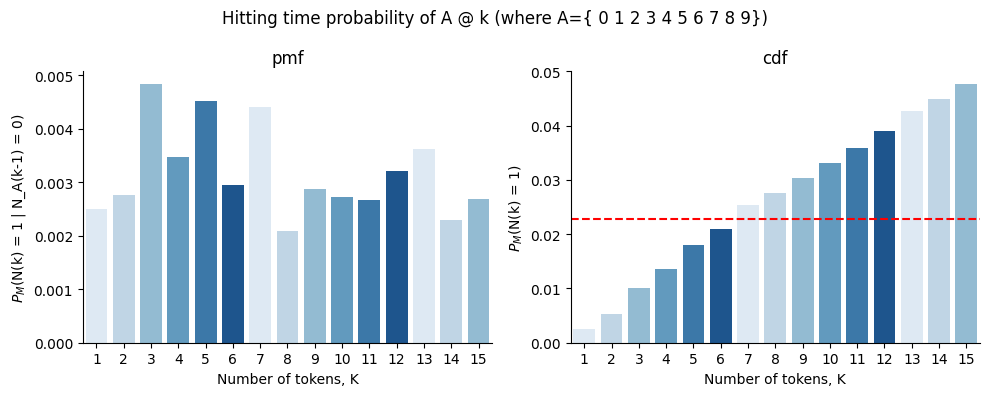

In [7]:
### Probability of uttering a number
digits = " 0 1 2 3 4 5 6 7 8 9"
data_digits_prob = compute_proxy_term_frequency(digits)
print("Empirical frequency:",  data_digits_prob)

model_hit_probs, _ = model_estimate(avoid_terms=digits)
print(f"Model likelihood (up to {MAX_NUM_TOKENS}):",  sum(model_hit_probs))

hitting_time_plots(digits, num_tokens=MAX_NUM_TOKENS, model_probs=model_hit_probs, data_probs=data_digits_prob)

Empirical frequency: 0.005367482138474269


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 13020.40it/s]


Model likelihood (up to 15): 0.007578798889881


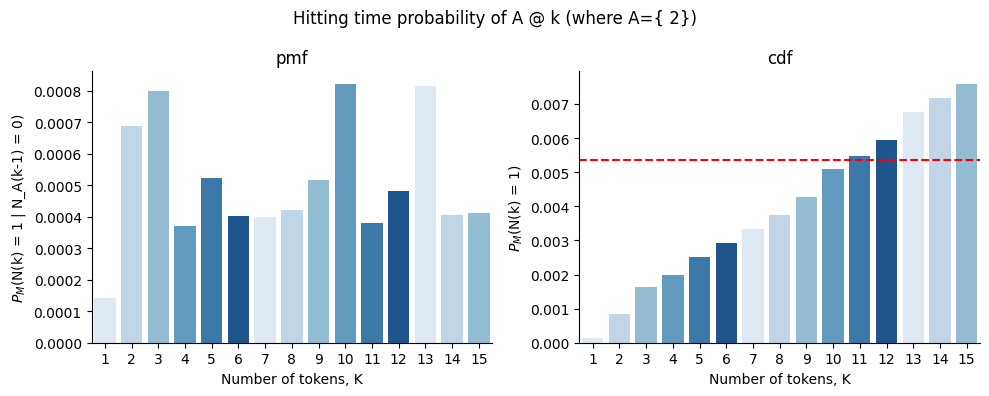

In [8]:
### Probability of uttering a number
digits = " 2"
data_digits_prob = compute_proxy_term_frequency(digits)
print("Empirical frequency:",  data_digits_prob)

model_hit_probs, _ = model_estimate(avoid_terms=digits)
print(f"Model likelihood (up to {MAX_NUM_TOKENS}):",  sum(model_hit_probs))

hitting_time_plots(digits, num_tokens=MAX_NUM_TOKENS, model_probs=model_hit_probs, data_probs=data_digits_prob)

Empirical frequency: 0.005048159597090071


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 13506.78it/s]

Model likelihood (up to 15): 0.008202692377381027


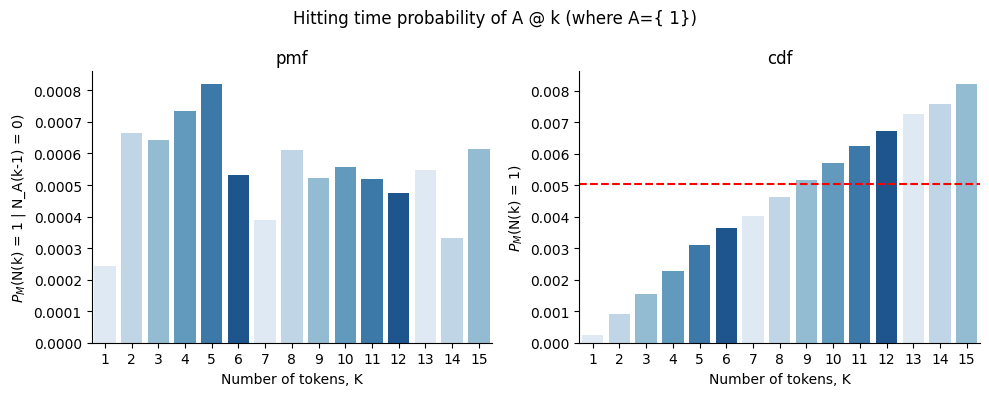

In [9]:
### Probability of uttering a number
digits = " 1"
data_digits_prob = compute_proxy_term_frequency(digits)
print("Empirical frequency:",  data_digits_prob)

model_hit_probs, _ = model_estimate(avoid_terms=digits)
print(f"Model likelihood (up to {MAX_NUM_TOKENS}):",  sum(model_hit_probs))

hitting_time_plots(digits, num_tokens=MAX_NUM_TOKENS, model_probs=model_hit_probs, data_probs=data_digits_prob)

Empirical frequency: 0.002921738015269111


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 13653.33it/s]

Model likelihood (up to 15): 0.006758718634955585


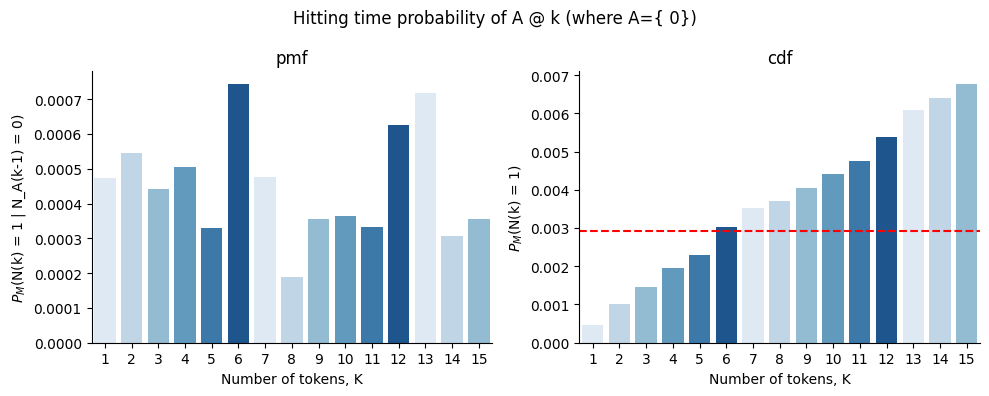

In [10]:
### Probability of uttering a number
digits = " 0"
data_digits_prob = compute_proxy_term_frequency(digits)
print("Empirical frequency:",  data_digits_prob)

model_hit_probs, _ = model_estimate(avoid_terms=digits)
print(f"Model likelihood (up to {MAX_NUM_TOKENS}):",  sum(model_hit_probs))

hitting_time_plots(digits, num_tokens=MAX_NUM_TOKENS, model_probs=model_hit_probs, data_probs=data_digits_prob)

Empirical frequency: 0.0019329941068756623


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 12625.84it/s]

Model likelihood (up to 15): 0.0043126464588567615


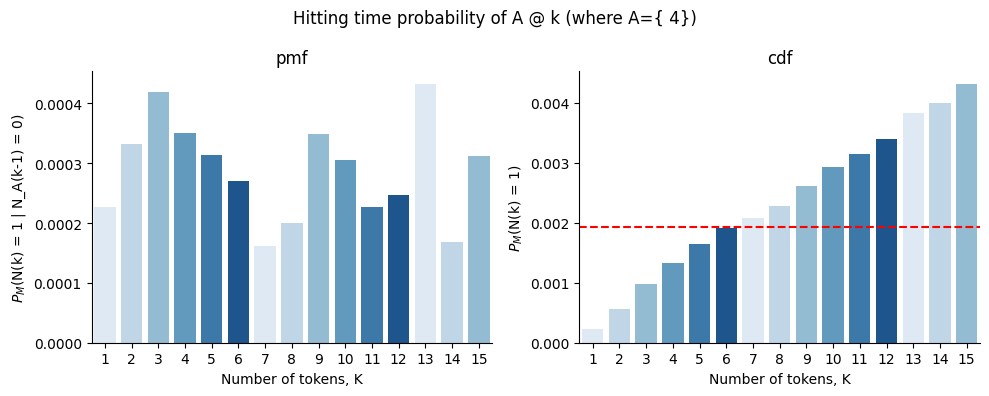

In [15]:
### Probability of uttering a number
digits = " 4"
data_digits_prob = compute_proxy_term_frequency(digits)
print("Empirical frequency:",  data_digits_prob)

model_hit_probs, _ = model_estimate(avoid_terms=digits)
print(f"Model likelihood (up to {MAX_NUM_TOKENS}):",  sum(model_hit_probs))

hitting_time_plots(digits, num_tokens=MAX_NUM_TOKENS, model_probs=model_hit_probs, data_probs=data_digits_prob)

Empirical frequency: 0.11028579736583859


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 13659.26it/s]

Model likelihood (up to 15): 0.04252984875347465


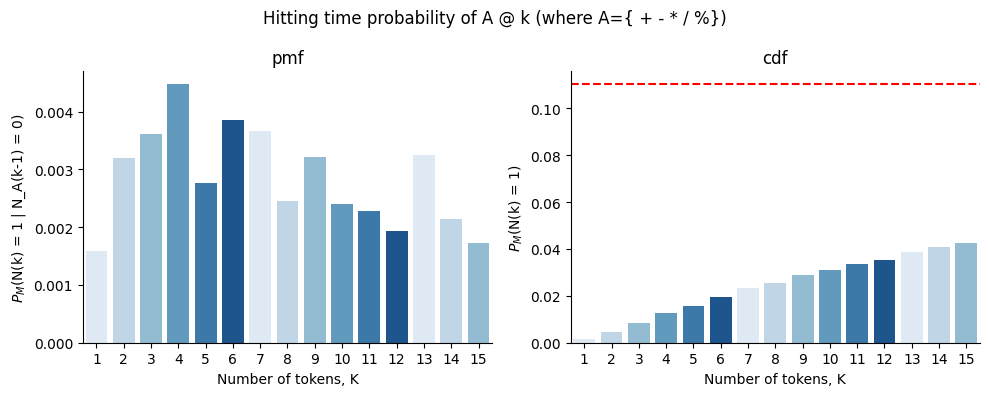

In [11]:
### Probability of uttering a number
operations = " + - * / %"
data_digits_prob = compute_proxy_term_frequency(operations)
print("Empirical frequency:",  data_digits_prob)

model_hit_probs, _ = model_estimate(avoid_terms=operations)
print(f"Model likelihood (up to {MAX_NUM_TOKENS}):",  sum(model_hit_probs))

hitting_time_plots(operations, num_tokens=MAX_NUM_TOKENS, model_probs=model_hit_probs, data_probs=data_digits_prob)

Empirical frequency: 0.0018928005076846379


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 13239.60it/s]

Model likelihood (up to 15): 0.005449306860100478


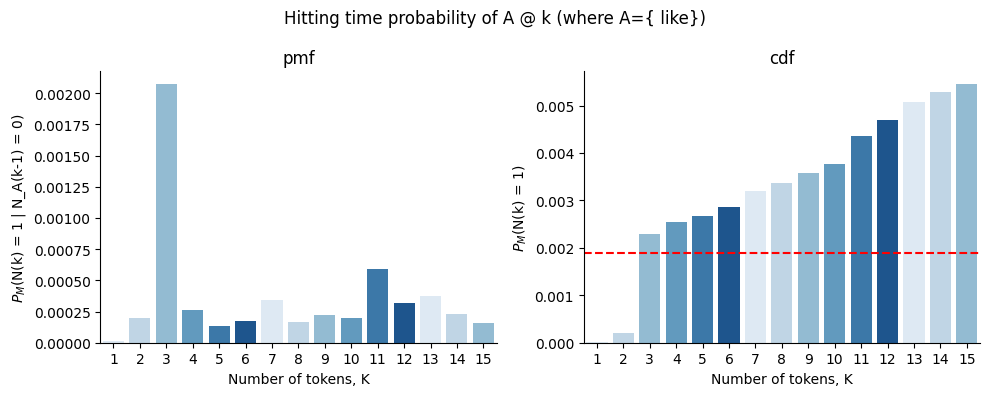

In [12]:
### Probability of uttering a number
operations = " like"
data_digits_prob = compute_proxy_term_frequency(operations)
print("Empirical frequency:",  data_digits_prob)

model_hit_probs, _ = model_estimate(avoid_terms=operations)
print(f"Model likelihood (up to {MAX_NUM_TOKENS}):",  sum(model_hit_probs))

hitting_time_plots(operations, num_tokens=MAX_NUM_TOKENS, model_probs=model_hit_probs, data_probs=data_digits_prob)

Empirical frequency: 0.011283554915074039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 12409.18it/s]

Model likelihood (up to 15): 0.015468206169316545


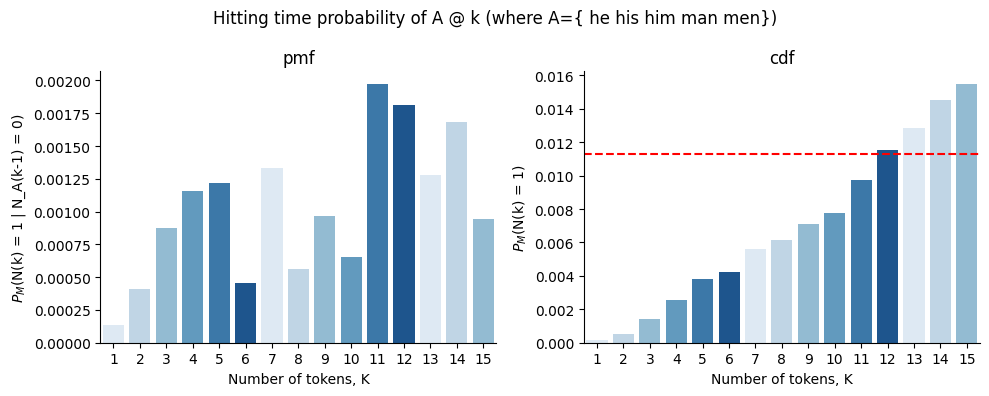

In [16]:
### Probability of uttering a masculine pronoun
operations = " he his him man men"
data_digits_prob = compute_proxy_term_frequency(operations)
print("Empirical frequency:",  data_digits_prob)

model_hit_probs, _ = model_estimate(avoid_terms=operations)
print(f"Model likelihood (up to {MAX_NUM_TOKENS}):",  sum(model_hit_probs))

hitting_time_plots(operations, num_tokens=MAX_NUM_TOKENS, model_probs=model_hit_probs, data_probs=data_digits_prob)

Empirical frequency: 0.005266661156885422


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 12873.86it/s]

Model likelihood (up to 15): 0.007772663200739771


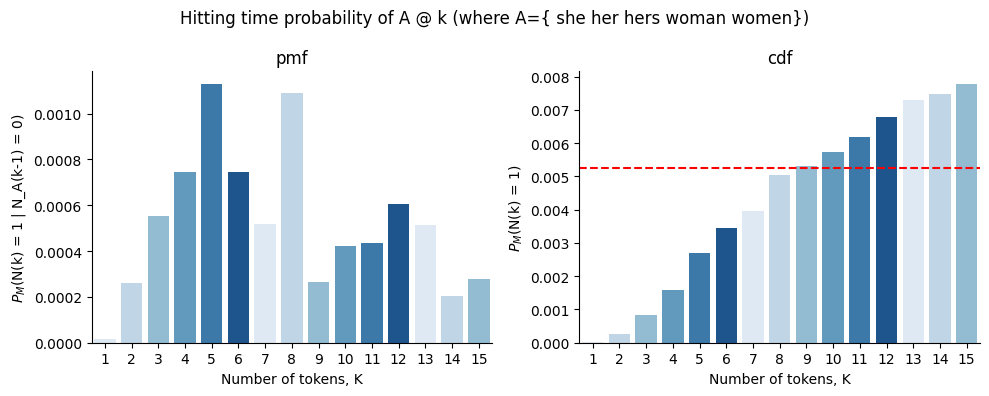

In [18]:
### Probability of uttering a masculine pronoun
operations = " she her hers woman women"
data_digits_prob = compute_proxy_term_frequency(operations)
print("Empirical frequency:",  data_digits_prob)

model_hit_probs, _ = model_estimate(avoid_terms=operations)
print(f"Model likelihood (up to {MAX_NUM_TOKENS}):",  sum(model_hit_probs))

hitting_time_plots(operations, num_tokens=MAX_NUM_TOKENS, model_probs=model_hit_probs, data_probs=data_digits_prob)

Empirical frequency: 0.001933633634046263


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 13709.86it/s]

Model likelihood (up to 15): 0.00906063147704117


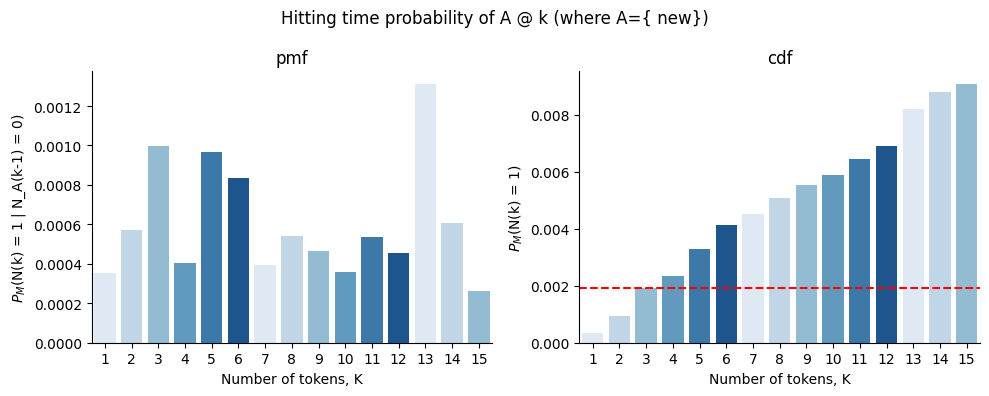

In [19]:
### Probability of uttering a number
operations = " time"
data_digits_prob = compute_proxy_term_frequency(operations)
print("Empirical frequency:",  data_digits_prob)

model_hit_probs, _ = model_estimate(avoid_terms=operations)
print(f"Model likelihood (up to {MAX_NUM_TOKENS}):",  sum(model_hit_probs))

hitting_time_plots(operations, num_tokens=MAX_NUM_TOKENS, model_probs=model_hit_probs, data_probs=data_digits_prob)

Empirical frequency: 0.00014351579822799944


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 13736.80it/s]

Model likelihood (up to 15): 0.00020080680565115472


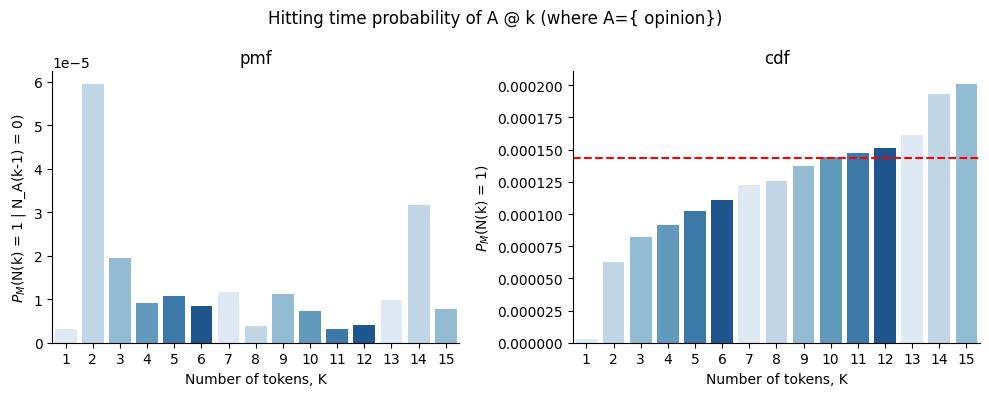

In [20]:
### Probability of uttering a number
operations = " opinion"
data_digits_prob = compute_proxy_term_frequency(operations)
print("Empirical frequency:",  data_digits_prob)

model_hit_probs, _ = model_estimate(avoid_terms=operations)
print(f"Model likelihood (up to {MAX_NUM_TOKENS}):",  sum(model_hit_probs))

hitting_time_plots(operations, num_tokens=MAX_NUM_TOKENS, model_probs=model_hit_probs, data_probs=data_digits_prob)

Empirical frequency: 0.0022014291238107025


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 13984.12it/s]

Model likelihood (up to 15): 0.004717455820355099


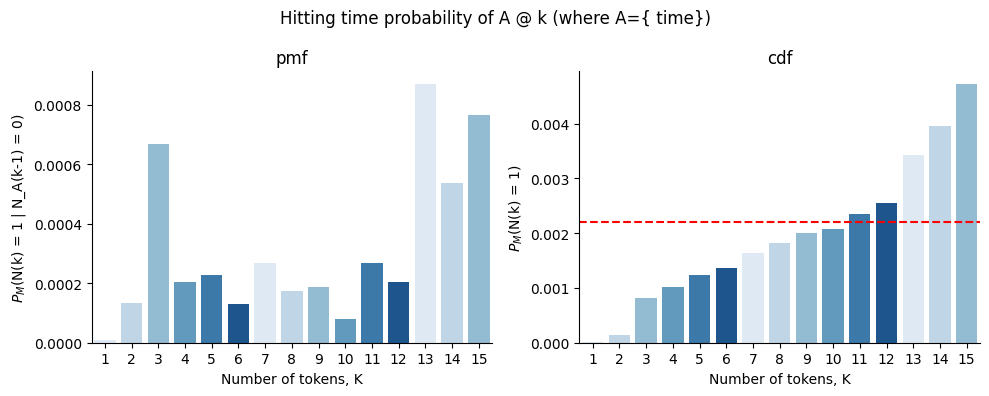

In [21]:
### Probability of uttering a number
operations = " time"
data_digits_prob = compute_proxy_term_frequency(operations)
print("Empirical frequency:",  data_digits_prob)

model_hit_probs, _ = model_estimate(avoid_terms=operations)
print(f"Model likelihood (up to {MAX_NUM_TOKENS}):",  sum(model_hit_probs))

hitting_time_plots(operations, num_tokens=MAX_NUM_TOKENS, model_probs=model_hit_probs, data_probs=data_digits_prob)

Empirical frequency: 0.0050405829938229745


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 12684.39it/s]

Model likelihood (up to 15): 0.0007609350914208335


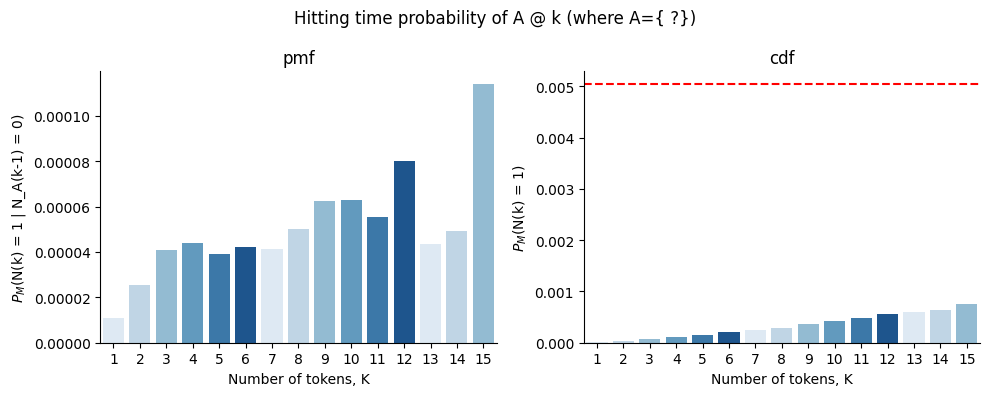

In [37]:
### Probability of uttering a number
operations = "? ?"
data_digits_prob = compute_proxy_term_frequency(operations)
print("Empirical frequency:",  data_digits_prob)

model_hit_probs, _ = model_estimate(avoid_terms=operations)
print(f"Model likelihood (up to {MAX_NUM_TOKENS}):",  sum(model_hit_probs))

hitting_time_plots(operations, num_tokens=MAX_NUM_TOKENS, model_probs=model_hit_probs, data_probs=data_digits_prob)

In [38]:
SORTED_TERM_FREQUENCY[20:40]

[('said', 219624681),
 ('let', 214854845),
 ('right', 210372007),
 ('5', 203326682),
 ('data', 185481838),
 ('him', 180492358),
 ('use', 178440341),
 ('de', 175490127),
 ('—', 165260341),
 ('people', 162993693),
 ('left', 156408815),
 ('10', 149302738),
 ('–', 141041870),
 ('ref', 138696295),
 ('end', 135763276),
 ('fig', 134599262),
 ('state', 134028647),
 ('way', 133317081),
 ('know', 133039064),
 ('6', 132820600)]

Empirical frequency: 0.001522998926927084


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 13443.28it/s]

Model likelihood (up to 15): 0.0004652010557038011


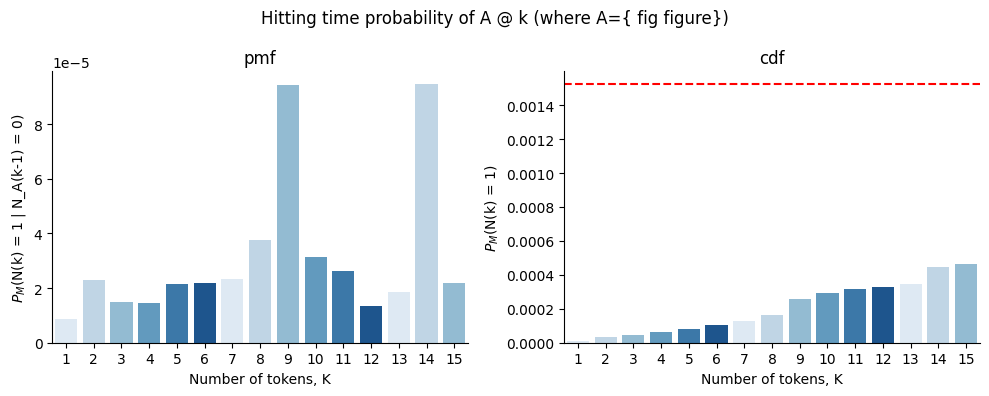

In [47]:
### Probability of uttering a number
operations = " fig figure"
data_digits_prob = compute_proxy_term_frequency(operations)
print("Empirical frequency:",  data_digits_prob)

model_hit_probs, _ = model_estimate(avoid_terms=operations)
print(f"Model likelihood (up to {MAX_NUM_TOKENS}):",  sum(model_hit_probs))

hitting_time_plots(operations, num_tokens=MAX_NUM_TOKENS, model_probs=model_hit_probs, data_probs=data_digits_prob)

Empirical frequency: 0.0014300434610896773


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 13503.88it/s]

Model likelihood (up to 15): 0.0017442465905332938


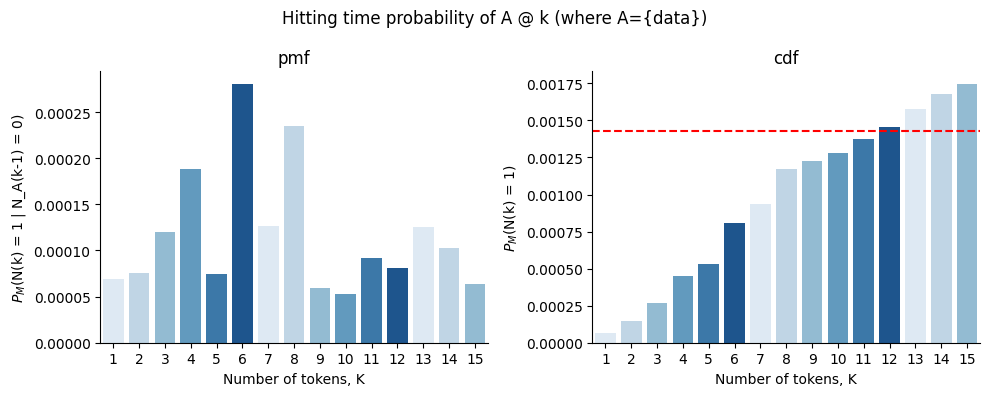

In [46]:
### Probability of uttering a number
operations = "data"
data_digits_prob = compute_proxy_term_frequency(operations)
print("Empirical frequency:",  data_digits_prob)

model_hit_probs, _ = model_estimate(avoid_terms=operations)
print(f"Model likelihood (up to {MAX_NUM_TOKENS}):",  sum(model_hit_probs))

hitting_time_plots(operations, num_tokens=MAX_NUM_TOKENS, model_probs=model_hit_probs, data_probs=data_digits_prob)